## Loading wav files

https://www.kaggle.com/competitions/tensorflow-speech-recognition-challenge

In [26]:
import os 

import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
signal, sr = librosa.load('data/raw/audio/bed/00f0204f_nohash_0.wav')
audio_len = len(signal)

In [36]:
def generate_mel_spectogram(signal, sr, dataset, folder, filename):
    # this is the number of samples in a window per fft
    n_fft = 2048
    # The amount of samples we are shifting after each fft
    hop_length = 512

    mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, 
    n_fft=n_fft)

    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(8, 7))
    librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma', 
    hop_length=hop_length)
    plt.axis('off')
    save_dir = f'data/processed/{dataset}/{folder}'
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f'{save_dir}/{filename[:-4]}.png', pad_inches=-0.1, bbox_inches='tight')



In [ ]:
folders_known = ['up', 'down', 'left', 'right', 'on', 'off', 'yes', 'no']
path = 'data/raw/audio'
for folder in folders_known:
    for filename in os.listdir(f'{path}/{folder}'):
        signal, sr = librosa.load(f'{path}/{folder}/{filename}')
        generate_mel_spectogram(signal, sr, folder, filename)

        

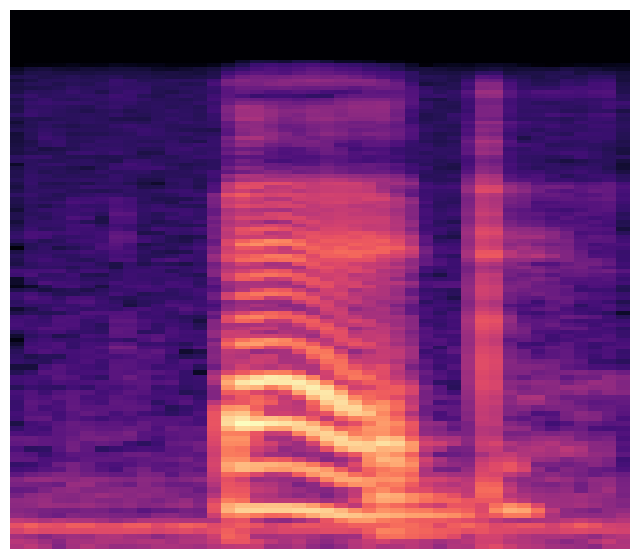

In [37]:
generate_mel_spectogram(signal, sr, 'folder_test', 'test4')

## Standarization of the audio data

In order to standardize the audio data, we will extend shorter files with silence to ensure all files have equal duration of sound.